In [7]:
# load all units for movie/shuffled stationary and for spontaneous stationary
# take activity averages across time and compare unit activity
# filter units based on activity
# create report similar to sfn_panel3

# Unit Activity Report

In [26]:
%load_ext autoreload
%autoreload 2

In [21]:
# imports
import numpy as np
import pandas as pd
import neo
from tqdm import tqdm
import os

# custom
import sys
sys.path.append("../../")
from allen_vc.plots import sync_plot
from allen_vc.stats import run_hierarchical_bootstrap

print("Packages Imported!")

Packages Imported!


### Load units

In [9]:
PROJECT_PATH = "G:/Shared drives/visual_encoding"

In [10]:
dir_results = f"{PROJECT_PATH}/data/blocks/segmented"

In [11]:
# for each session
    # load spont_stationary block, get first segment
    # for each unit
        # for each segment in spont_stationary
            # average firing rate and store
            
        # for each segment in spont_running
            # average firing rate and store
            
        # for each segment in movie
            # average firing rate and store
            
        # for each segment in shuffled
            # average firing rate and store
            
        # average movie and shuffled rates and store
            
        # if spont_stationary >= stim
            # provide print statement
            # delete unit from shuffled and stim blocks
            
        # if spont_stationary >= spont_running
            # provide print statement
            # delete unit from shuffled and stim blocks

# save out filtered block

In [14]:
dir_spontaneous_stationary = f"{PROJECT_PATH}/data/blocks/segmented/spontaneous_stationary"
dir_spontaneous_running = f"{PROJECT_PATH}/data/blocks/segmented/spontaneous_running"
dir_movie = f"{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_more_repeats"
dir_shuffled = f"{PROJECT_PATH}/data/blocks/segmented/natural_movie_one_shuffled"

for file in tqdm(os.listdir(dir_movie)):
    
    if file.split('.')[-1]!='mat':
        continue
    
    stationary_block = neo.io.NeoMatlabIO(filename=f"{dir_spontaneous_stationary}/{file}").read_block()
    running_block = neo.io.NeoMatlabIO(filename=f"{dir_spontaneous_running}/{file}").read_block()
    movie_block = neo.io.NeoMatlabIO(filename=f"{dir_movie}/{file}").read_block()
    shuff_block = neo.io.NeoMatlabIO(filename=f"{dir_shuffled}/{file}").read_block()
    session_id = file.split('_')[1].split('.')[0]
    
    print(f"STARTING SESSION: {session_id}")
    
    if len(stationary_block.segments)==0:
        print("No stationary spontaneous segments for comparison!")
        continue
    
    movie_block.segments = np.array(movie_block.segments)[~movie_block.annotations['running']]
    shuff_block.segments = np.array(shuff_block.segments)[~shuff_block.annotations['running']]
    
    total_units = 0
    stim_dropped_units = 0
    spont_dropped_units = 0
    
    for i_train, spiketrain in enumerate(stationary_block.segments[0].spiketrains):
        
        unit_id = spiketrain.annotations['unit_id']
        
        stationary_avg = 0
        running_avg = 0
        stim_avg = 0
        
        for segment in stationary_block.segments:
            
            spikes = segment.spiketrains[i_train-spont_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in stationary"
            
            mfr = (len(spikes)/spikes.duration).magnitude
            stationary_avg = (stationary_avg + mfr)/2
            
        for segment in running_block.segments:
            
            spikes = segment.spiketrains[i_train-spont_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in running"
            
            mfr = (len(spikes)/spikes.duration).magnitude
            running_avg = (running_avg + mfr)/2
            
        for segment in movie_block.segments:
            
            spikes = segment.spiketrains[i_train-stim_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in movie"
            
            mfr = (len(spikes)/spikes.duration).magnitude
            stim_avg = (stim_avg + mfr)/2
            
        for segment in shuff_block.segments:
            
            spikes = segment.spiketrains[i_train-stim_dropped_units]
            assert spikes.annotations['unit_id'] == unit_id, f"Unit {unit_id} not aligned in shuffled"
            
            mfr = (len(spikes)/spikes.duration).magnitude
            stim_avg = (stim_avg + mfr)/2
        
        if stim_avg <= stationary_avg:
            
            print(f"\tDropping Stim Unit: {unit_id}")
            
            for segment in movie_block.segments:
                
                segment.spiketrains = segment.spiketrains[:i_train-stim_dropped_units] + segment.spiketrains[i_train-stim_dropped_units+1:]
            

            for segment in shuff_block.segments:

                segment.spiketrains = segment.spiketrains[:i_train-stim_dropped_units] + segment.spiketrains[i_train-stim_dropped_units+1:]
                
            stim_dropped_units += 1
            
        if running_avg <= stationary_avg:
            
            print(f"\tDropping Spont Unit: {unit_id}")
            
            for segment in stationary_block.segments:
                
                segment.spiketrains = segment.spiketrains[:i_train-spont_dropped_units] + segment.spiketrains[i_train-spont_dropped_units+1:]
            

            for segment in running_block.segments:

                segment.spiketrains = segment.spiketrains[:i_train-spont_dropped_units] + segment.spiketrains[i_train-spont_dropped_units+1:]
                
            spont_dropped_units += 1
            
        total_units += 1
        
    print(f"DROPPED {stim_dropped_units}/{total_units} STIM UNITS")
    print(f"DROPPED {spont_dropped_units}/{total_units} SPONT UNITS\n\n")
                
    neo.io.NeoMatlabIO(f"{dir_results}/natural_movie_one_more_repeats_filtered/{file}").write_block(movie_block)
    neo.io.NeoMatlabIO(f"{dir_results}/natural_movie_one_shuffled_filtered/{file}").write_block(shuff_block)
    neo.io.NeoMatlabIO(f"{dir_results}/spontaneous_stationary_filtered/{file}").write_block(stationary_block)
    neo.io.NeoMatlabIO(f"{dir_results}/spontaneous_running_filtered/{file}").write_block(running_block)

  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

STARTING SESSION: 847657808
	Dropping Stim Unit: 951187131
	Dropping Stim Unit: 951187147
	Dropping Spont Unit: 951187147
	Dropping Spont Unit: 951187145
	Dropping Stim Unit: 951187143
	Dropping Stim Unit: 951187139
	Dropping Spont Unit: 951187139
	Dropping Stim Unit: 951187149
	Dropping Stim Unit: 951187151
	Dropping Stim Unit: 951187161
	Dropping Spont Unit: 951187161
	Dropping Stim Unit: 951187188
	Dropping Spont Unit: 951187188
	Dropping Spont Unit: 951187198
	Dropping Spont Unit: 951187200
	Dropping Spont Unit: 951187216
	Dropping Spont Unit: 951187212
	Dropping Spont Unit: 951187210
	Dropping Spont Unit: 951187208
	Dropping Spont Unit: 951187222
	Dropping Spont Unit: 951187218
	Dropping Spont Unit: 951187230
	Dropping Spont Unit: 951187224
	Dropping Spont Unit: 951187228
	Dropping Spont Unit: 951187244
	Dropping Spont Unit: 951187258
	Dropping Spont Unit: 951187240
	Dropping Spont Unit: 951187236
	Dropping Stim Unit: 951187250
	Dropping Spont Unit: 951187250
	Dropping Stim Unit: 

  4%|███▌                                                                               | 1/23 [00:09<03:31,  9.61s/it]

STARTING SESSION: 840012044
	Dropping Stim Unit: 951143596
	Dropping Spont Unit: 951143596
	Dropping Stim Unit: 951143567
	Dropping Stim Unit: 951143733
	Dropping Stim Unit: 951143700
	Dropping Spont Unit: 951143700
	Dropping Spont Unit: 951143721
	Dropping Stim Unit: 951143770
	Dropping Stim Unit: 951143776
	Dropping Spont Unit: 951143776
	Dropping Stim Unit: 951143807
	Dropping Spont Unit: 951143807
	Dropping Spont Unit: 951144766
	Dropping Stim Unit: 951143852
	Dropping Spont Unit: 951143852
	Dropping Stim Unit: 951143919
	Dropping Stim Unit: 951143912
	Dropping Spont Unit: 951143912
	Dropping Stim Unit: 951143933
	Dropping Spont Unit: 951143908
	Dropping Stim Unit: 951143895
	Dropping Spont Unit: 951143895
	Dropping Stim Unit: 951143881
	Dropping Spont Unit: 951143881
	Dropping Spont Unit: 951143954
	Dropping Spont Unit: 951143991
	Dropping Stim Unit: 951143947
	Dropping Spont Unit: 951143947
	Dropping Stim Unit: 951143984
	Dropping Spont Unit: 951143984
	Dropping Stim Unit: 951144

  9%|███████▏                                                                           | 2/23 [00:14<02:18,  6.62s/it]

STARTING SESSION: 839068429
	Dropping Stim Unit: 951173095
	Dropping Stim Unit: 951173103
	Dropping Spont Unit: 951173103
	Dropping Stim Unit: 951173114
	Dropping Spont Unit: 951173114
	Dropping Stim Unit: 951173124
	Dropping Spont Unit: 951173124
	Dropping Stim Unit: 951173128
	Dropping Spont Unit: 951173128
	Dropping Stim Unit: 951173132
	Dropping Spont Unit: 951173132
	Dropping Stim Unit: 951173138
	Dropping Spont Unit: 951173134
	Dropping Stim Unit: 951173147
	Dropping Spont Unit: 951173147
	Dropping Spont Unit: 951173172
	Dropping Spont Unit: 951173159
	Dropping Stim Unit: 951173157
	Dropping Spont Unit: 951173157
	Dropping Stim Unit: 951173151
	Dropping Spont Unit: 951173151
	Dropping Spont Unit: 951173505
	Dropping Spont Unit: 951173165
	Dropping Stim Unit: 951173174
	Dropping Spont Unit: 951173174
	Dropping Stim Unit: 951173188
	Dropping Spont Unit: 951173186
	Dropping Stim Unit: 951173194
	Dropping Stim Unit: 951173212
	Dropping Spont Unit: 951173212
	Dropping Spont Unit: 9511

 13%|██████████▊                                                                        | 3/23 [00:27<03:10,  9.54s/it]

STARTING SESSION: 835479236
	Dropping Stim Unit: 951166038
	Dropping Spont Unit: 951166064
	Dropping Stim Unit: 951166058
	Dropping Stim Unit: 951166072
	Dropping Spont Unit: 951166072
	Dropping Stim Unit: 951166090
	Dropping Spont Unit: 951166090
	Dropping Stim Unit: 951166084
	Dropping Spont Unit: 951166084
	Dropping Stim Unit: 951166100
	Dropping Spont Unit: 951166581
	Dropping Spont Unit: 951166131
	Dropping Spont Unit: 951166150
	Dropping Stim Unit: 951166161
	Dropping Spont Unit: 951166161
	Dropping Stim Unit: 951166165
	Dropping Spont Unit: 951166165
	Dropping Stim Unit: 951166169
	Dropping Spont Unit: 951166169
	Dropping Stim Unit: 951166179
	Dropping Spont Unit: 951166179
	Dropping Spont Unit: 951166203
	Dropping Stim Unit: 951166211
	Dropping Spont Unit: 951166193
	Dropping Spont Unit: 951166191
	Dropping Spont Unit: 951166591
	Dropping Spont Unit: 951166209
	Dropping Spont Unit: 951166235
	Dropping Stim Unit: 951166241
	Dropping Stim Unit: 951166237
	Dropping Spont Unit: 951

 22%|██████████████████                                                                 | 5/23 [00:46<02:40,  8.93s/it]

STARTING SESSION: 831882777
No stationary spontaneous segments for comparison!
STARTING SESSION: 829720705
	Dropping Stim Unit: 951132060
	Dropping Spont Unit: 951132060
	Dropping Spont Unit: 951132054
	Dropping Stim Unit: 951132379
	Dropping Spont Unit: 951132379
	Dropping Spont Unit: 951132066
	Dropping Stim Unit: 951132064
	Dropping Spont Unit: 951132064
	Dropping Spont Unit: 951132062
	Dropping Spont Unit: 951132381
	Dropping Stim Unit: 951132070
	Dropping Spont Unit: 951132070
	Dropping Spont Unit: 951132078
	Dropping Spont Unit: 951132090
	Dropping Spont Unit: 951132092
	Dropping Spont Unit: 951132112
	Dropping Spont Unit: 951132124
	Dropping Spont Unit: 951132138
	Dropping Stim Unit: 951132136
	Dropping Spont Unit: 951132136
	Dropping Spont Unit: 951132140
	Dropping Spont Unit: 951132393
	Dropping Stim Unit: 951132395
	Dropping Spont Unit: 951132395
	Dropping Spont Unit: 951132153
	Dropping Stim Unit: 951132159
	Dropping Spont Unit: 951132159
	Dropping Spont Unit: 951132175
	Dro

 26%|█████████████████████▋                                                             | 6/23 [00:55<02:29,  8.81s/it]

STARTING SESSION: 821695405
	Dropping Stim Unit: 951097246
	Dropping Stim Unit: 951097850
	Dropping Stim Unit: 951097933
	Dropping Stim Unit: 951099768
	Dropping Stim Unit: 951098023
	Dropping Spont Unit: 951098009
	Dropping Stim Unit: 951098061
	Dropping Spont Unit: 951098061
	Dropping Spont Unit: 951098046
	Dropping Stim Unit: 951098214
	Dropping Spont Unit: 951098406
	Dropping Stim Unit: 951098373
	Dropping Spont Unit: 951098373
	Dropping Stim Unit: 951098363
	Dropping Spont Unit: 951098363
	Dropping Stim Unit: 951098451
	Dropping Spont Unit: 951098451
	Dropping Stim Unit: 951098419
	Dropping Spont Unit: 951098419
	Dropping Stim Unit: 951098518
	Dropping Spont Unit: 951098518
	Dropping Stim Unit: 951098468
	Dropping Spont Unit: 951098703
	Dropping Stim Unit: 951098893
	Dropping Stim Unit: 951098716
	Dropping Spont Unit: 951098716
	Dropping Spont Unit: 951098954
DROPPED 15/34 STIM UNITS
DROPPED 12/34 SPONT UNITS




 30%|█████████████████████████▎                                                         | 7/23 [01:00<02:01,  7.62s/it]

STARTING SESSION: 816200189
	Dropping Spont Unit: 951155297
	Dropping Stim Unit: 951155285
	Dropping Spont Unit: 951155285
	Dropping Spont Unit: 951155343
	Dropping Spont Unit: 951155382
	Dropping Stim Unit: 951155371
	Dropping Spont Unit: 951155371
	Dropping Spont Unit: 951155399
	Dropping Spont Unit: 951155393
	Dropping Stim Unit: 951155435
	Dropping Spont Unit: 951155435
	Dropping Spont Unit: 951155468
	Dropping Spont Unit: 951155463
	Dropping Spont Unit: 951155534
	Dropping Spont Unit: 951155581
	Dropping Spont Unit: 951155570
	Dropping Spont Unit: 951155565
	Dropping Stim Unit: 951155609
	Dropping Spont Unit: 951155609
	Dropping Stim Unit: 951155598
	Dropping Spont Unit: 951155598
	Dropping Spont Unit: 951155591
	Dropping Spont Unit: 951155614
	Dropping Spont Unit: 951155575
	Dropping Stim Unit: 951155655
	Dropping Spont Unit: 951155655
	Dropping Spont Unit: 951155650
	Dropping Spont Unit: 951155644
	Dropping Stim Unit: 951155639
	Dropping Spont Unit: 951155639
	Dropping Spont Uni

 35%|████████████████████████████▊                                                      | 8/23 [01:13<02:18,  9.21s/it]

STARTING SESSION: 794812542
	Dropping Spont Unit: 951086929
	Dropping Stim Unit: 951089048
	Dropping Spont Unit: 951089048
	Dropping Stim Unit: 951087009
	Dropping Spont Unit: 951087009
	Dropping Spont Unit: 951086949
	Dropping Spont Unit: 951086934
	Dropping Spont Unit: 951089059
	Dropping Spont Unit: 951086999
	Dropping Spont Unit: 951089668
	Dropping Stim Unit: 951086967
	Dropping Spont Unit: 951086967
	Dropping Spont Unit: 951087168
	Dropping Stim Unit: 951087087
	Dropping Spont Unit: 951087087
	Dropping Stim Unit: 951087127
	Dropping Spont Unit: 951087127
	Dropping Spont Unit: 951087117
	Dropping Spont Unit: 951087080
	Dropping Stim Unit: 951087026
	Dropping Spont Unit: 951087026
	Dropping Spont Unit: 951087248
	Dropping Spont Unit: 951087198
	Dropping Spont Unit: 951087277
	Dropping Spont Unit: 951087323
	Dropping Stim Unit: 951087364
	Dropping Spont Unit: 951087364
	Dropping Spont Unit: 951087437
	Dropping Stim Unit: 951087445
	Dropping Spont Unit: 951087445
	Dropping Spont Unit

 39%|████████████████████████████████▍                                                  | 9/23 [01:30<02:42, 11.60s/it]

STARTING SESSION: 793224716
	Dropping Spont Unit: 951065341
	Dropping Stim Unit: 951065337
	Dropping Spont Unit: 951065337
	Dropping Stim Unit: 951066274
	Dropping Spont Unit: 951066274
	Dropping Stim Unit: 951065443
	Dropping Stim Unit: 951065439
	Dropping Spont Unit: 951065439
	Dropping Stim Unit: 951065419
	Dropping Stim Unit: 951065431
	Dropping Spont Unit: 951065431
	Dropping Spont Unit: 951065467
	Dropping Spont Unit: 951066470
	Dropping Spont Unit: 951066288
	Dropping Stim Unit: 951065480
	Dropping Spont Unit: 951065480
	Dropping Spont Unit: 951066296
	Dropping Spont Unit: 951065496
	Dropping Stim Unit: 951065488
	Dropping Spont Unit: 951065488
	Dropping Spont Unit: 951065548
	Dropping Stim Unit: 951065534
	Dropping Spont Unit: 951065534
	Dropping Stim Unit: 951065526
	Dropping Stim Unit: 951065586
	Dropping Stim Unit: 951066314
	Dropping Spont Unit: 951066314
	Dropping Stim Unit: 951066524
	Dropping Spont Unit: 951066524
	Dropping Spont Unit: 951065716
	Dropping Stim Unit: 9510

 43%|███████████████████████████████████▋                                              | 10/23 [01:45<02:46, 12.80s/it]

STARTING SESSION: 789848216
	Dropping Stim Unit: 951058504
	Dropping Spont Unit: 951058522
	Dropping Spont Unit: 951058511
	Dropping Stim Unit: 951058518
	Dropping Spont Unit: 951058518
	Dropping Stim Unit: 951058579
	Dropping Spont Unit: 951058600
	Dropping Spont Unit: 951058596
	Dropping Spont Unit: 951058607
	Dropping Spont Unit: 951058625
	Dropping Spont Unit: 951058617
	Dropping Stim Unit: 951058705
	Dropping Spont Unit: 951058705
DROPPED 4/14 STIM UNITS
DROPPED 9/14 SPONT UNITS




 48%|███████████████████████████████████████▏                                          | 11/23 [01:47<01:52,  9.35s/it]

STARTING SESSION: 787025148
	Dropping Stim Unit: 951022169
	Dropping Stim Unit: 951022229
	Dropping Stim Unit: 951022327
	Dropping Spont Unit: 951022327
	Dropping Stim Unit: 951022319
	Dropping Stim Unit: 951024457
	Dropping Stim Unit: 951022400
	Dropping Stim Unit: 951022390
	Dropping Stim Unit: 951022446
	Dropping Stim Unit: 951022503
	Dropping Spont Unit: 951022503
	Dropping Stim Unit: 951022558
	Dropping Stim Unit: 951022631
	Dropping Spont Unit: 951022685
	Dropping Stim Unit: 951022661
	Dropping Stim Unit: 951022739
	Dropping Stim Unit: 951022720
	Dropping Spont Unit: 951022720
	Dropping Stim Unit: 951022748
	Dropping Stim Unit: 951022804
	Dropping Stim Unit: 951022793
	Dropping Spont Unit: 951022793
	Dropping Stim Unit: 951022782
	Dropping Spont Unit: 951022782
	Dropping Stim Unit: 951024490
	Dropping Spont Unit: 951022903
	Dropping Stim Unit: 951022880
	Dropping Stim Unit: 951022976
	Dropping Stim Unit: 951022965
	Dropping Stim Unit: 951022916
	Dropping Spont Unit: 951022916
	Dr

 57%|██████████████████████████████████████████████▎                                   | 13/23 [01:58<01:11,  7.16s/it]

STARTING SESSION: 786091066
No stationary spontaneous segments for comparison!
STARTING SESSION: 781842082
	Dropping Stim Unit: 951005552
	Dropping Spont Unit: 951005552
	Dropping Stim Unit: 951005494
	Dropping Stim Unit: 951005483
	Dropping Spont Unit: 951005599
	Dropping Spont Unit: 951005580
	Dropping Stim Unit: 951005681
	Dropping Stim Unit: 951005750
	Dropping Spont Unit: 951005730
	Dropping Spont Unit: 951005723
	Dropping Spont Unit: 951005799
	Dropping Spont Unit: 951005792
	Dropping Stim Unit: 951007503
	Dropping Spont Unit: 951007503
	Dropping Spont Unit: 951005818
	Dropping Stim Unit: 951005863
	Dropping Stim Unit: 951005910
	Dropping Spont Unit: 951005910
	Dropping Spont Unit: 951005899
	Dropping Stim Unit: 951005890
	Dropping Spont Unit: 951005890
	Dropping Spont Unit: 951005873
	Dropping Spont Unit: 951005962
	Dropping Stim Unit: 951005942
	Dropping Spont Unit: 951005922
	Dropping Spont Unit: 951006044
	Dropping Spont Unit: 951006026
	Dropping Stim Unit: 951006017
	Droppin

 61%|█████████████████████████████████████████████████▉                                | 14/23 [02:09<01:15,  8.38s/it]

STARTING SESSION: 779839471
	Dropping Spont Unit: 951011404
	Dropping Spont Unit: 951011414
	Dropping Spont Unit: 951011333
	Dropping Stim Unit: 951011315
	Dropping Spont Unit: 951011315
	Dropping Stim Unit: 951011300
	Dropping Spont Unit: 951015434
	Dropping Spont Unit: 951015552
	Dropping Spont Unit: 951011609
	Dropping Stim Unit: 951011557
	Dropping Spont Unit: 951011557
	Dropping Stim Unit: 951011527
	Dropping Spont Unit: 951011527
	Dropping Spont Unit: 951011594
	Dropping Spont Unit: 951011758
	Dropping Spont Unit: 951011919
	Dropping Stim Unit: 951011871
	Dropping Spont Unit: 951011871
	Dropping Stim Unit: 951012023
	Dropping Spont Unit: 951012023
	Dropping Spont Unit: 951011977
	Dropping Spont Unit: 951012130
	Dropping Spont Unit: 951012181
	Dropping Spont Unit: 951012169
	Dropping Spont Unit: 951012345
	Dropping Stim Unit: 951012324
	Dropping Stim Unit: 951012303
	Dropping Spont Unit: 951012303
	Dropping Spont Unit: 951012487
	Dropping Stim Unit: 951012470
	Dropping Spont Unit:

 65%|█████████████████████████████████████████████████████▍                            | 15/23 [02:40<02:01, 15.15s/it]

STARTING SESSION: 778998620
	Dropping Stim Unit: 951020561
	Dropping Stim Unit: 951020698
	Dropping Stim Unit: 951020666
	Dropping Stim Unit: 951021029
	Dropping Stim Unit: 951021083
	Dropping Stim Unit: 951021415
	Dropping Stim Unit: 951021364
	Dropping Stim Unit: 951021536
	Dropping Spont Unit: 951021536
	Dropping Stim Unit: 951021685
	Dropping Stim Unit: 951021997
	Dropping Spont Unit: 951021997
	Dropping Stim Unit: 951021970
	Dropping Stim Unit: 951021938
	Dropping Stim Unit: 951022115
	Dropping Spont Unit: 951022323
	Dropping Spont Unit: 951022270
	Dropping Spont Unit: 951022239
	Dropping Spont Unit: 951022194
	Dropping Stim Unit: 951022413
	Dropping Spont Unit: 951022348
	Dropping Spont Unit: 951022680
	Dropping Stim Unit: 951022481
	Dropping Stim Unit: 951022541
	Dropping Stim Unit: 951026977
	Dropping Spont Unit: 951022706
	Dropping Stim Unit: 951022812
	Dropping Spont Unit: 951022812
	Dropping Stim Unit: 951022780
	Dropping Stim Unit: 951023057
	Dropping Stim Unit: 951023028
	

 70%|█████████████████████████████████████████████████████████                         | 16/23 [02:55<01:46, 15.15s/it]

STARTING SESSION: 778240327
	Dropping Stim Unit: 951026044
	Dropping Spont Unit: 951026044
	Dropping Spont Unit: 951026138
	Dropping Stim Unit: 951026244
	Dropping Stim Unit: 951026372
	Dropping Stim Unit: 951026397
	Dropping Stim Unit: 951026428
	Dropping Stim Unit: 951026419
	Dropping Spont Unit: 951026589
	Dropping Spont Unit: 951026570
	Dropping Stim Unit: 951026481
	Dropping Stim Unit: 951026611
	Dropping Spont Unit: 951026611
	Dropping Stim Unit: 951026620
	Dropping Stim Unit: 951026659
	Dropping Spont Unit: 951026810
	Dropping Stim Unit: 951026996
	Dropping Stim Unit: 951027031
	Dropping Spont Unit: 951027031
	Dropping Stim Unit: 951027107
	Dropping Spont Unit: 951027096
	Dropping Stim Unit: 951027194
	Dropping Spont Unit: 951027194
	Dropping Stim Unit: 951027138
	Dropping Stim Unit: 951027313
	Dropping Stim Unit: 951027432
	Dropping Stim Unit: 951027930
	Dropping Stim Unit: 951027999
DROPPED 19/87 STIM UNITS
DROPPED 9/87 SPONT UNITS




 74%|████████████████████████████████████████████████████████████▌                     | 17/23 [03:06<01:23, 13.87s/it]

STARTING SESSION: 774875821
	Dropping Stim Unit: 950989464
	Dropping Spont Unit: 950989452
	Dropping Stim Unit: 950989447
	Dropping Spont Unit: 950989447
	Dropping Stim Unit: 950989550
	Dropping Spont Unit: 950989550
	Dropping Spont Unit: 950989558
	Dropping Stim Unit: 950990333
	Dropping Spont Unit: 950990333
	Dropping Stim Unit: 950989565
	Dropping Spont Unit: 950989565
	Dropping Spont Unit: 950989586
	Dropping Stim Unit: 950989603
	Dropping Spont Unit: 950989603
	Dropping Spont Unit: 950989648
	Dropping Spont Unit: 950989623
	Dropping Spont Unit: 950989619
	Dropping Spont Unit: 950989616
	Dropping Spont Unit: 950989590
	Dropping Spont Unit: 950989611
	Dropping Spont Unit: 950989660
	Dropping Stim Unit: 950989652
	Dropping Spont Unit: 950989652
	Dropping Stim Unit: 950989607
	Dropping Spont Unit: 950989607
	Dropping Spont Unit: 950989664
	Dropping Stim Unit: 950989708
	Dropping Spont Unit: 950989708
	Dropping Spont Unit: 950989700
	Dropping Stim Unit: 950989697
	Dropping Spont Unit: 

 78%|████████████████████████████████████████████████████████████████▏                 | 18/23 [03:16<01:03, 12.73s/it]

STARTING SESSION: 771990200
	Dropping Spont Unit: 950991768
	Dropping Spont Unit: 950992008
	Dropping Stim Unit: 950992002
	Dropping Stim Unit: 950992032
	Dropping Spont Unit: 950992032
	Dropping Stim Unit: 950992066
	Dropping Stim Unit: 950992147
	Dropping Spont Unit: 950992147
	Dropping Spont Unit: 950992183
	Dropping Spont Unit: 950992214
	Dropping Stim Unit: 950992202
	Dropping Spont Unit: 950992202
	Dropping Stim Unit: 950992259
	Dropping Stim Unit: 950992247
	Dropping Spont Unit: 950992247
	Dropping Spont Unit: 950992240
	Dropping Spont Unit: 950992220
	Dropping Spont Unit: 950992288
	Dropping Stim Unit: 950992362
	Dropping Spont Unit: 950992334
	Dropping Stim Unit: 950992324
	Dropping Spont Unit: 950992324
	Dropping Spont Unit: 950992484
	Dropping Stim Unit: 950992474
	Dropping Stim Unit: 950992443
	Dropping Spont Unit: 950992381
	Dropping Stim Unit: 950993447
	Dropping Stim Unit: 950992493
	Dropping Spont Unit: 950992493
	Dropping Stim Unit: 950992616
	Dropping Spont Unit: 9509

 83%|███████████████████████████████████████████████████████████████████▋              | 19/23 [03:38<01:01, 15.48s/it]

STARTING SESSION: 771160300
	Dropping Spont Unit: 950925715
	Dropping Spont Unit: 950922495
	Dropping Spont Unit: 950922511
	Dropping Stim Unit: 950922446
	Dropping Spont Unit: 950922546
	Dropping Spont Unit: 950922627
	Dropping Spont Unit: 950922595
	Dropping Stim Unit: 950922746
	Dropping Spont Unit: 950922746
	Dropping Spont Unit: 950922805
	Dropping Spont Unit: 950922974
	Dropping Spont Unit: 950922916
	Dropping Spont Unit: 950923086
	Dropping Spont Unit: 950923073
	Dropping Spont Unit: 950923022
	Dropping Stim Unit: 950923133
	Dropping Spont Unit: 950923133
	Dropping Stim Unit: 950923360
	Dropping Stim Unit: 950923289
	Dropping Spont Unit: 950923289
	Dropping Spont Unit: 950925846
	Dropping Stim Unit: 950925829
	Dropping Spont Unit: 950923446
	Dropping Stim Unit: 950923630
	Dropping Spont Unit: 950923577
	Dropping Stim Unit: 950923546
	Dropping Stim Unit: 950923529
	Dropping Spont Unit: 950923515
	Dropping Spont Unit: 950923495
	Dropping Spont Unit: 950923751
	Dropping Stim Unit: 

 87%|███████████████████████████████████████████████████████████████████████▎          | 20/23 [03:51<00:44, 14.85s/it]

STARTING SESSION: 768515987
	Dropping Stim Unit: 950935782
	Dropping Stim Unit: 950935835
	Dropping Spont Unit: 950935835
	Dropping Stim Unit: 950936059
	Dropping Stim Unit: 950936348
	Dropping Spont Unit: 950936485
	Dropping Stim Unit: 950936603
	Dropping Spont Unit: 950936603
	Dropping Spont Unit: 950936588
	Dropping Stim Unit: 950936692
	Dropping Spont Unit: 950936692
	Dropping Stim Unit: 950936638
	Dropping Spont Unit: 950936638
	Dropping Stim Unit: 950936757
	Dropping Stim Unit: 950936725
	Dropping Spont Unit: 950936725
	Dropping Stim Unit: 950936959
	Dropping Spont Unit: 950936959
	Dropping Spont Unit: 950936947
	Dropping Stim Unit: 950936934
	Dropping Spont Unit: 950936934
	Dropping Spont Unit: 950936918
	Dropping Stim Unit: 950939191
	Dropping Spont Unit: 950939191
	Dropping Stim Unit: 950936864
	Dropping Spont Unit: 950936864
	Dropping Stim Unit: 950937047
	Dropping Spont Unit: 950937047
	Dropping Stim Unit: 950938909
	Dropping Spont Unit: 950938909
	Dropping Stim Unit: 950937

 91%|██████████████████████████████████████████████████████████████████████████▊       | 21/23 [04:10<00:32, 16.07s/it]

STARTING SESSION: 767871931
	Dropping Stim Unit: 950928046
	Dropping Stim Unit: 950928177
	Dropping Spont Unit: 950928177
	Dropping Spont Unit: 950928163
	Dropping Stim Unit: 950928146
	Dropping Spont Unit: 950928146
	Dropping Stim Unit: 950928389
	Dropping Spont Unit: 950928389
	Dropping Stim Unit: 950928339
	Dropping Stim Unit: 950928420
	Dropping Spont Unit: 950928420
	Dropping Stim Unit: 950928373
	Dropping Spont Unit: 950928487
	Dropping Stim Unit: 950928621
	Dropping Spont Unit: 950929025
	Dropping Stim Unit: 950928997
	Dropping Stim Unit: 950928962
	Dropping Stim Unit: 950928945
	Dropping Spont Unit: 950928945
	Dropping Stim Unit: 950928910
	Dropping Spont Unit: 950929145
	Dropping Stim Unit: 950929128
	Dropping Spont Unit: 950929055
	Dropping Spont Unit: 950932115
	Dropping Stim Unit: 950929212
	Dropping Spont Unit: 950929212
	Dropping Stim Unit: 950929161
	Dropping Spont Unit: 950929161
	Dropping Spont Unit: 950929260
	Dropping Stim Unit: 950929243
	Dropping Stim Unit: 9509293

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 22/23 [04:31<00:17, 17.57s/it]

STARTING SESSION: 766640955
	Dropping Stim Unit: 950929267
	Dropping Spont Unit: 950929267
	Dropping Spont Unit: 950929299
	Dropping Stim Unit: 950931534
	Dropping Spont Unit: 950929433
	Dropping Stim Unit: 950929417
	Dropping Spont Unit: 950929417
	Dropping Stim Unit: 950931556
	Dropping Stim Unit: 950929451
	Dropping Spont Unit: 950929451
	Dropping Stim Unit: 950929536
	Dropping Spont Unit: 950929583
	Dropping Spont Unit: 950929641
	Dropping Stim Unit: 950929723
	Dropping Spont Unit: 950929680
	Dropping Spont Unit: 950929775
	Dropping Spont Unit: 950929833
	Dropping Stim Unit: 950929874
	Dropping Spont Unit: 950929874
	Dropping Stim Unit: 950929988
	Dropping Spont Unit: 950929988
	Dropping Spont Unit: 950929846
	Dropping Spont Unit: 950929943
	Dropping Stim Unit: 950929916
	Dropping Spont Unit: 950929916
	Dropping Spont Unit: 950929889
	Dropping Spont Unit: 950930055
	Dropping Stim Unit: 950930042
	Dropping Spont Unit: 950930042
	Dropping Spont Unit: 950930027
	Dropping Spont Unit: 9

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [04:55<00:00, 12.83s/it]


In [ ]:
# NOTES: Only stationary movies from movie and shuffled are kept, if no stationary epochs exist for a session,
# the session is thrown out, if no running epochs, then all spont units are thrown out

### Compute Spike Stats

In [ ]:
# HERE: RUN code/compute_spike_stats.py for each condition

### Plot Metric Comparisons

In [17]:
# load spike stats from spontaneous block
df_running = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_running_filtered.csv').assign(state='running').assign(block='behavior')
df_stationary = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/spontaneous_stationary_filtered.csv').assign(state='stationary').assign(block='behavior')

# load spike stats from movie blocks
df_movie = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_more_repeats_filtered.csv').assign(state='movie').assign(block='presentation')
df_shuffled = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/region_metrics/natural_movie_one_shuffled_filtered.csv').assign(state='shuffled').assign(block='presentation')

# join
metric_df = pd.concat([df_running, df_stationary, df_movie, df_shuffled], ignore_index=True).drop(columns=['running'])

In [18]:
metric_df

,session,brain_structure,epoch_idx,epoch_times,mean_firing_rate,coefficient_of_variation,spike_distance,spike_synchrony,state,block
0,847657808,VISp,0,"[5512.0, 5542.0]",0.044887,1.170267,0.226058,0.352825,running,behavior
1,847657808,VISp,1,"[6015.08, 6045.08]",0.042095,0.974263,0.222261,0.366814,running,behavior
2,840012044,VISp,0,"[4419.1, 4449.1]",0.056922,1.070635,0.202938,0.345624,running,behavior
3,840012044,VISp,1,"[5476.84, 5506.84]",0.046442,1.075518,0.211914,0.344866,running,behavior
4,839068429,VISp,0,"[4391.54, 4421.54]",0.045316,1.104341,0.181475,0.373481,running,behavior
...,...,...,...,...,...,...,...,...,...,...
2446,766640955,LGd,13,"[7281.377594154052, 7311.38]",0.055803,1.054920,0.172543,0.317514,shuffled,presentation
2447,766640955,VISp,14,"[7311.400000000001, 7341.402674154052]",0.035139,1.612719,0.189233,0.328230,shuffled,presentation
2448,766640955,LGd,14,"[7311.400000000001, 7341.402674154052]",0.059287,1.073533,0.174810,0.316631,shuffled,presentation
2449,766640955,VISp,15,"[7341.42, 7371.427734154053]",0.036139,1.461433,0.190401,0.331916,shuffled,presentation


In [33]:
metric_df.isna().sum()

session                       0
brain_structure               0
epoch_idx                     0
epoch_times                   0
mean_firing_rate            159
coefficient_of_variation    160
spike_distance              159
spike_synchrony             159
state                         0
block                         0
dtype: int64

In [37]:
metric_df[metric_df['coefficient_of_variation'].isna()]['state'].value_counts()

state
stationary    159
running         1
Name: count, dtype: int64

In [32]:
metric_df[metric_df['state'] == 'stationary']

,session,brain_structure,epoch_idx,epoch_times,mean_firing_rate,coefficient_of_variation,spike_distance,spike_synchrony,state,block
409,847657808,VISp,0,"[4427.179999999999, 4457.179999999999]",0.037586,0.957486,0.159542,0.372907,stationary,behavior
410,847657808,VISp,1,"[4457.179999999999, 4487.179999999999]",0.026258,1.126189,0.130180,0.365421,stationary,behavior
411,847657808,VISp,2,"[4487.179999999999, 4517.179999999999]",0.037426,1.032704,0.159012,0.367560,stationary,behavior
412,847657808,VISp,3,"[4517.179999999999, 4547.179999999999]",0.030918,1.103472,0.135565,0.369620,stationary,behavior
413,847657808,VISp,4,"[4547.179999999999, 4577.179999999999]",0.025446,1.154891,0.122601,0.365612,stationary,behavior
...,...,...,...,...,...,...,...,...,...,...
1322,766640955,LGd,41,"[6086.98, 6116.98]",0.061598,1.081693,0.238763,0.327119,stationary,behavior
1323,766640955,VISp,42,"[6116.98, 6146.98]",0.019435,1.359260,0.130182,0.356217,stationary,behavior
1324,766640955,LGd,42,"[6116.98, 6146.98]",0.047842,1.080720,0.226804,0.325392,stationary,behavior
1325,766640955,VISp,43,"[6146.98, 6176.98]",0.025687,1.194617,0.160624,0.361715,stationary,behavior


In [39]:
# drop null values
metric_df = metric_df.dropna()

In [46]:
# define metrics to be plotted 
metrics = ['mean_firing_rate', 'spike_distance']
conditions = ['running', 'stationary', 'movie', 'shuffled']

p_vals = [[0.0, 0.424], [0.0, 0.09], [0.003, 0.13], [0.185,0.459]]
colors = ['#d62728', '#ff7f0e', '#1f77b4', '#2ca02c']

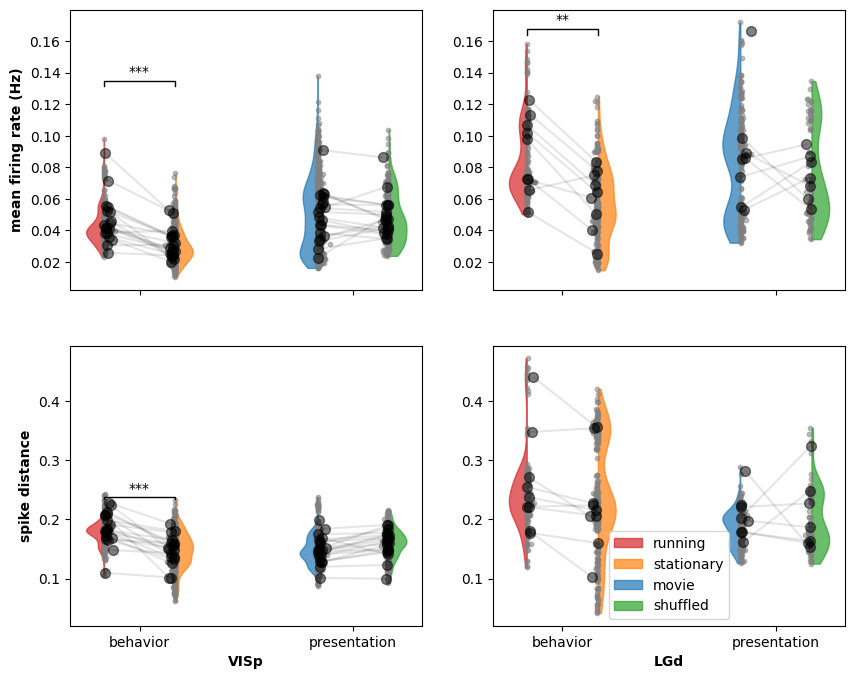

In [52]:
# plot all epochs
sync_plot(metric_df, metrics, conditions, alpha=0.7, p_vals=p_vals,
          ylabels=['mean firing rate (Hz)', 'spike distance'], colors=colors);

In [42]:
# IS THIS STILL NECESSARY?

# # remove outliers
# no_outliers_metric_df = metric_df[metric_df['spike_distance'] < 1]

# # plot
# sync_plot(no_outliers_metric_df, metrics, conditions, p_vals=p_vals, alpha=0.7, 
#           ylabels=['mean firing rate (Hz)', 'spike distance'], colors=colors);

### Hierarchical Bootstrap

In [43]:
# Set default parameters for hierarchical bootstrap
bootstrap_params = {
    'df': None,
    'variable': None,
    'condition': 'state',
    'level_1': 'session',
    'level_2': 'epoch_idx',
    'verbose': True,
    'plot': True
}

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.0
p-boot: 9.4e-05


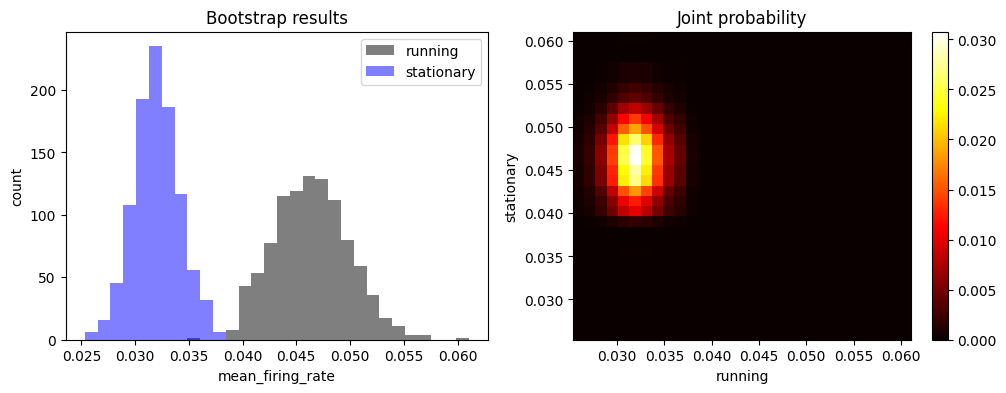

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.424
p-boot: 0.45272999999999997


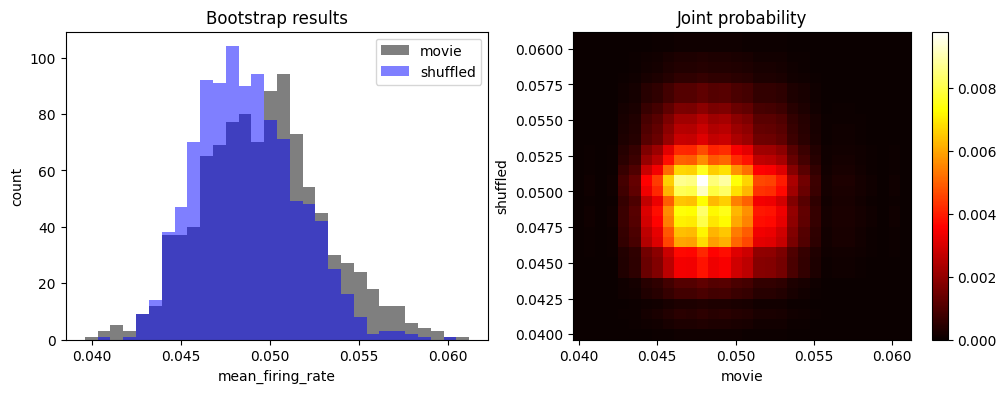

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.003
p-boot: 0.002101


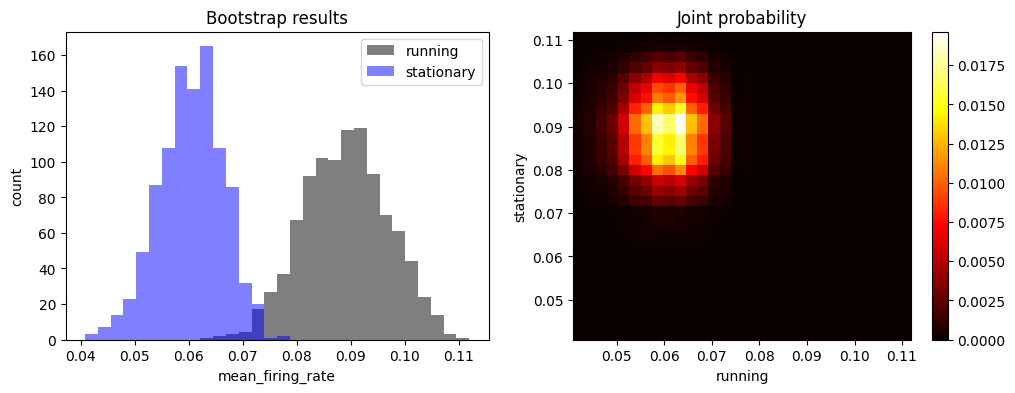

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'mean_firing_rate' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.13
p-boot: 0.159641


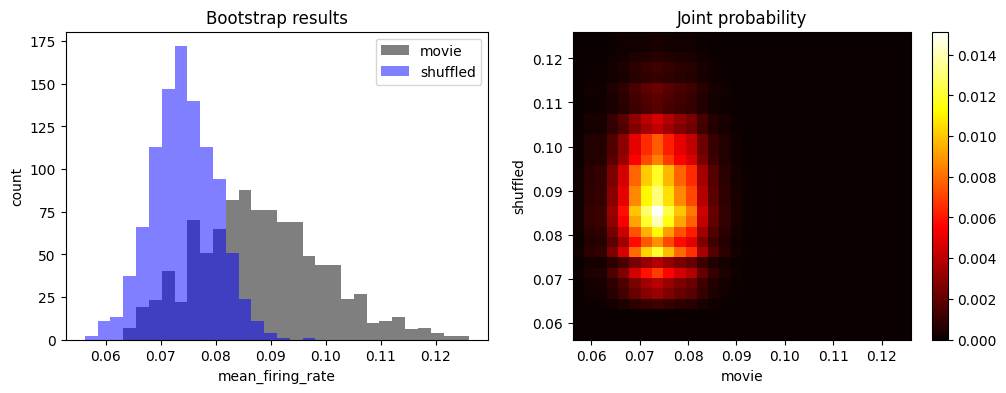

In [44]:
# offset analysis
variable = 'mean_firing_rate'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'VISp' FOR 'behavior' TRIALS


p-value: 0.0
p-boot: 1.5e-05


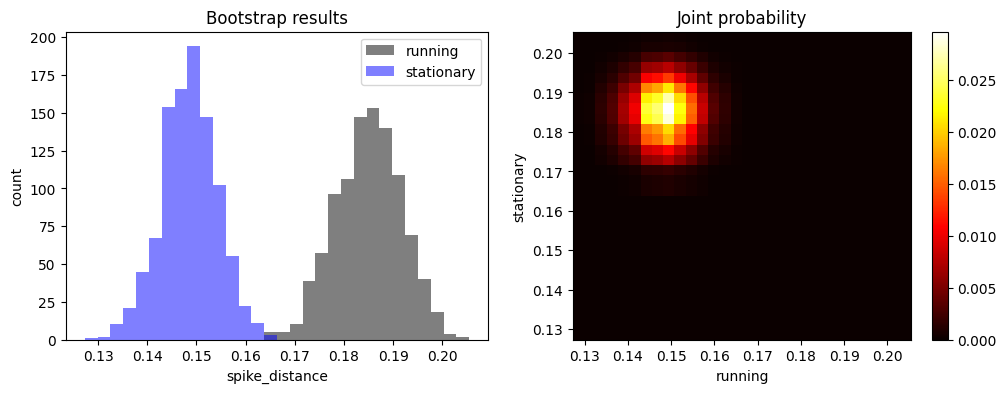

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'VISp' FOR 'presentation' TRIALS


p-value: 0.09
p-boot: 0.9251340000000001


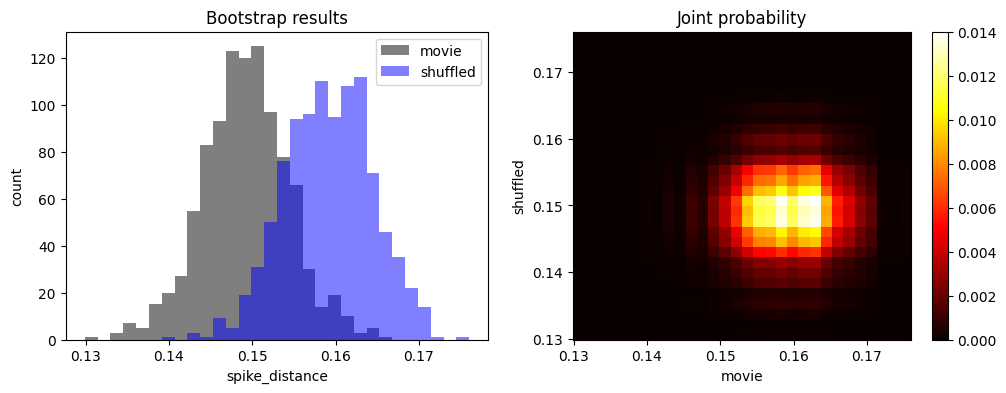

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'LGd' FOR 'behavior' TRIALS


p-value: 0.185
p-boot: 0.21909800000000001


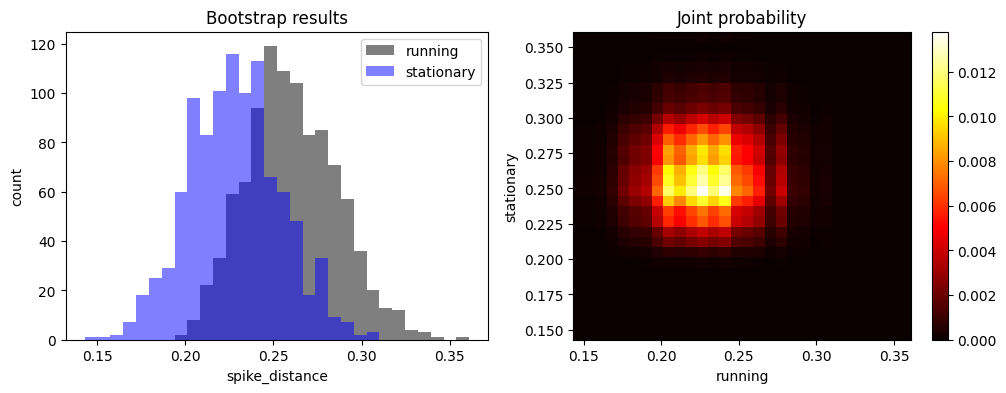

COMPUTING HIERARCHICAL BOOTSTRAP FOR 'spike_distance' IN 'LGd' FOR 'presentation' TRIALS


p-value: 0.459
p-boot: 0.574502


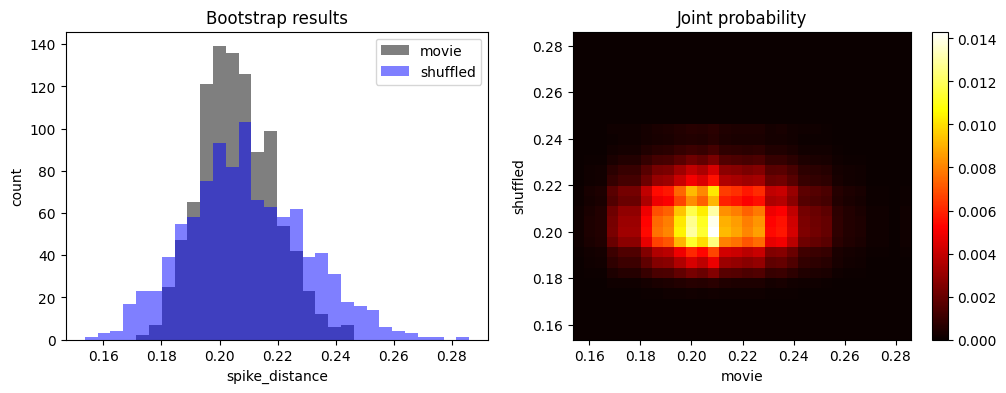

In [45]:
# spike-distance analysis
variable = 'spike_distance'
bootstrap_params['variable'] = variable
for region in metric_df['brain_structure'].unique():
    for block in metric_df['block'].unique():
        print(f'COMPUTING HIERARCHICAL BOOTSTRAP FOR \'{variable}\' IN \'{region}\' FOR \'{block}\' TRIALS\n\n')
        
        bootstrap_params['df'] = metric_df[(metric_df['brain_structure']==region)&(metric_df['block']==block)]
        
        run_hierarchical_bootstrap(**bootstrap_params)